In [1]:
import zipfile

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [6]:
from lightgbm.sklearn import LGBMClassifier

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [8]:
from xgboost import XGBRFClassifier

In [372]:
!kaggle competitions download -c spaceship-titanic


  0%|          | 0.00/299k [00:00<?, ?B/s]
100%|##########| 299k/299k [00:00<00:00, 937kB/s]
100%|##########| 299k/299k [00:00<00:00, 937kB/s]


In [241]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")

target = "Transported"

test[target] = -1

In [242]:
data = train.append(test)
data.reset_index(inplace=True, drop=True)
data.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
10251,3355_01,Earth,True,G/548/P,PSO J318.5-22,23.0,False,0.0,0.0,0.0,0.0,0.0,Blanie Fuenterson,-1
11580,6345_01,Mars,True,F/1211/S,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,0.0,0.0,Peefox Pashe,-1
9662,2021_01,Earth,True,G/320/S,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Andace Flynnis,-1
11303,5715_02,Europa,False,D/174/S,TRAPPIST-1e,51.0,False,0.0,3247.0,0.0,8.0,634.0,Hadlam Shantactal,-1
9588,1852_03,Europa,True,B/79/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Tachird Semootor,-1


In [243]:
data.shape

(12970, 14)

In [244]:
data.groupby("Cabin")[target].agg(lambda x: list(x)).sample(50)

Cabin
F/1025/S                [-1]
F/1836/P                [-1]
F/918/P                  [0]
C/19/S                   [0]
F/206/P                 [-1]
G/1349/P                 [1]
F/148/S                  [1]
G/352/P                  [1]
G/1403/P            [-1, -1]
E/574/S                  [1]
F/246/P                  [0]
F/1223/S                 [0]
G/1048/P                [-1]
G/91/S                   [1]
F/1511/S                [-1]
C/316/S                  [1]
F/1164/P                 [1]
B/29/P              [-1, -1]
G/887/S                  [1]
B/262/S                  [1]
B/235/P             [-1, -1]
G/805/S                  [1]
D/172/S                 [-1]
T/1/P                    [0]
B/155/P                 [-1]
A/49/P      [-1, -1, -1, -1]
E/52/S                  [-1]
C/204/P             [-1, -1]
C/89/P                  [-1]
A/1/S              [1, 1, 1]
F/1031/P                [-1]
F/195/P                  [0]
E/24/S                  [-1]
B/212/P                 [-1]
E/92/S  

In [245]:
p_count = pd.DataFrame({"p_count": data.groupby("Cabin")[target].agg("count")})
p_count.reset_index(inplace=True)
p_count

,Cabin,p_count
0,A/0/P,2
1,A/0/S,2
2,A/1/P,1
3,A/1/S,3
4,A/10/P,1
...,...,...
9820,T/2/P,1
9821,T/2/S,1
9822,T/3/P,1
9823,T/3/S,3


In [246]:
data = pd.merge(data, p_count, on="Cabin", how="left")
data.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,p_count
7726,8244_01,Earth,False,G/1337/P,TRAPPIST-1e,27.0,False,1007.0,0.0,0.0,9.0,0.0,Naomin Bailes,0,1.0
3059,3301_02,Earth,False,G/525/S,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,Tonald Domington,1,4.0
11553,6291_01,Earth,False,G/1019/S,TRAPPIST-1e,43.0,False,1009.0,0.0,3.0,0.0,0.0,Estina Cabrewsond,-1,1.0
476,0512_02,Europa,True,D/18/S,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,Ankalik Nateansive,1,2.0
5608,5969_01,Earth,True,G/972/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Janney Reenez,1,2.0


In [247]:
data.shape

(12970, 15)

In [248]:
data.nunique()

PassengerId     12970
HomePlanet          3
CryoSleep           2
Cabin            9825
Destination         3
Age                80
VIP                 2
RoomService      1578
FoodCourt        1953
ShoppingMall     1367
Spa              1679
VRDeck           1642
Name            12629
Transported         3
p_count             8
dtype: int64

In [249]:
data.isna().sum()

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
Transported       0
p_count         299
dtype: int64

In [250]:
mapping = {"HomePlanet": "Earth",
           "CryoSleep": 0,
           "Cabin": "X/000/X",
           "Destination": "TRAPPIST-1e",
           "Age": data["Age"].median(),
           "VIP": False,
           "RoomService": data["RoomService"].median(),
           "FoodCourt": data["FoodCourt"].median(),
           "ShoppingMall": data["ShoppingMall"].median(),
           "Spa": data["Spa"].median(),
           "VRDeck": data["VRDeck"].median(),
           "Name": "Peter Peter",
           "p_count": data["p_count"].median()
          }

In [251]:
for key, value in mapping.items():
    if  key in list(data.columns):
        mask = data[key].isna().values
        if len(mask):
            index = data.index[mask]
            data.loc[index, key] = value

In [252]:
# data.dropna(axis=0, inplace=True)

In [253]:
data.shape

(12970, 15)

In [254]:
data.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
p_count         0
dtype: int64

In [255]:
data["Pass"] = data["PassengerId"].apply(lambda x: int(str(x)[-2:]))
data["ID"] = data["PassengerId"].apply(lambda x: int(str(x)[:4]))

In [256]:
data["first"] = data["Cabin"].str[0]
data["second"] = data["Cabin"].str[-1]
data["middle"] = data["Cabin"].str[2:-2].astype("int")

In [257]:
data.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,p_count,Pass,ID,first,second,middle
2803,3025_01,Earth,False,G/477/S,TRAPPIST-1e,31.0,False,2.0,788.0,0.0,128.0,9.0,Peter Peter,1,2.0,1,3025,G,S,477
5362,5727_01,Earth,False,G/920/P,55 Cancri e,28.0,False,0.0,0.0,0.0,711.0,0.0,Kenny Santin,0,1.0,1,5727,G,P,920
3352,3608_02,Europa,True,D/122/P,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,0.0,0.0,Alhail Mormonized,1,3.0,2,3608,D,P,122
7531,8053_01,Mars,False,F/1663/P,TRAPPIST-1e,29.0,False,1544.0,1.0,206.0,0.0,0.0,Spix Burie,0,1.0,1,8053,F,P,1663
3250,3490_01,Europa,False,D/111/P,TRAPPIST-1e,29.0,False,4.0,3439.0,0.0,0.0,0.0,Meropus Sprender,1,2.0,1,3490,D,P,111


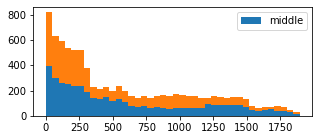

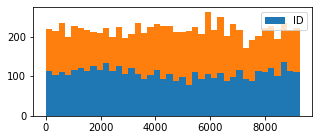

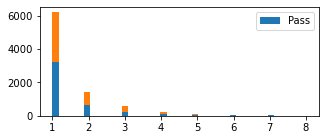

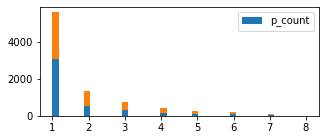

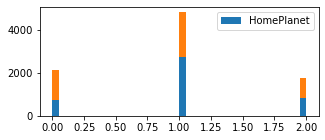

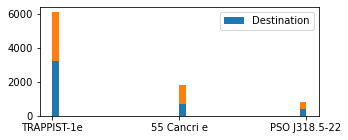

In [341]:
cols = ["middle", "ID", "Pass", "p_count", "HomePlanet", "Destination"] 

for col in cols:
    plt.figure(figsize=(5, 2))
    plt.hist([data[data[target] == 0][col], data[data[target] == 1][col]], stacked=True, bins=40, label=col)
    plt.legend()
    plt.show()

In [259]:
data.nunique()

PassengerId     12970
HomePlanet          3
CryoSleep           2
Cabin            9826
Destination         3
Age                80
VIP                 2
RoomService      1578
FoodCourt        1953
ShoppingMall     1367
Spa              1679
VRDeck           1642
Name            12630
Transported         3
p_count             8
Pass                8
ID               9280
first               9
second              3
middle           1894
dtype: int64

In [260]:
del data["PassengerId"]

In [261]:
del data["Cabin"]

In [262]:
del data["Name"]

In [263]:
mapping = {"Europa": 0, "Earth": 1, "Mars": 2, "NoName": 3}

data["HomePlanet"] = data["HomePlanet"].map(mapping).astype("int")

In [264]:
data.sample(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,p_count,Pass,ID,first,second,middle
8468,1,True,TRAPPIST-1e,25.0,False,0.0,0.0,0.0,0.0,0.0,1,1.0,1,9043,F,P,1848
8282,1,False,55 Cancri e,19.0,False,0.0,0.0,717.0,1.0,0.0,1,1.0,1,8844,E,S,579
4626,2,True,55 Cancri e,13.0,False,0.0,0.0,0.0,0.0,0.0,1,1.0,1,4929,F,P,1004
10657,1,True,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,0.0,-1,1.0,2,4235,G,S,694
6267,1,True,TRAPPIST-1e,64.0,False,0.0,0.0,0.0,0.0,0.0,1,1.0,2,6634,X,X,0


In [266]:
data.nunique()

HomePlanet         3
CryoSleep          2
Destination        3
Age               80
VIP                2
RoomService     1578
FoodCourt       1953
ShoppingMall    1367
Spa             1679
VRDeck          1642
Transported        3
p_count            8
Pass               8
ID              9280
first              9
second             3
middle          1894
dtype: int64

In [267]:
passenger = pd.get_dummies(data["Pass"], prefix="pss", drop_first=True)
homeplanet = pd.get_dummies(data["HomePlanet"], prefix="hp", drop_first=True)
destination = pd.get_dummies(data["Destination"], prefix="dst", drop_first=True)
cryosleep = pd.get_dummies(data["CryoSleep"], prefix="cs", drop_first=True)
vip = pd.get_dummies(data["VIP"], prefix="vp", drop_first=True)
first = pd.get_dummies(data["first"], prefix="frst", drop_first=True)
second = pd.get_dummies(data["second"], prefix="scnd", drop_first=True)

In [268]:
df = pd.concat([passenger, homeplanet, 
                destination, cryosleep, vip, first, second, 
                data[["Age",
                      "RoomService",
                      "FoodCourt",
                      "ShoppingMall",
                      "Spa",
                      "VRDeck",
                      "ID",
                      "middle",
                      "p_count",
                      target]]],
                axis=1)
df.sample(5)

,pss_2,pss_3,pss_4,pss_5,pss_6,pss_7,pss_8,hp_1,hp_2,dst_PSO J318.5-22,...,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,ID,middle,p_count,Transported
1477,0,0,0,0,0,0,0,0,0,0,...,37.0,0.0,0.0,0.0,0.0,0.0,1567,53,1.0,1
11783,0,0,0,0,0,0,0,1,0,0,...,26.0,0.0,0.0,0.0,0.0,0.0,6772,1099,1.0,-1
10431,0,0,0,0,0,0,0,0,1,0,...,27.0,0.0,0.0,0.0,0.0,0.0,3696,765,1.0,-1
9476,0,0,0,0,0,0,0,0,0,0,...,27.0,172.0,1.0,0.0,8999.0,20.0,1591,69,2.0,-1
11893,0,0,0,0,0,0,0,0,1,0,...,35.0,0.0,0.0,0.0,0.0,0.0,7000,1335,1.0,-1


In [269]:
df.shape

(12970, 33)

In [391]:
train_set = df[df[target] != -1].copy()
test_set = df[df[target] == -1].copy().drop(target, axis=1)

In [392]:
X = train_set.drop(target, axis=1)
y = train_set[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7)

In [393]:
scale = True

if scale:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

In [394]:
# clf = LogisticRegression(max_iter=1000)
clf = RidgeClassifier()
# clf = KNeighborsClassifier(n_neighbors=10)
# clf = AdaBoostClassifier()
# clf = ExtraTreesClassifier()
# clf = GradientBoostingClassifier()
# clf = LGBMClassifier(boosting_type="gbdt")
# clf = XGBRFClassifier(use_label_encoder=False, eval_metric="logloss")
# clf = RandomForestClassifier(max_depth=12)

clf.fit(X_train, y_train)

predict = clf.predict(X_val)
initial_score = np.sum(predict == y_val) / len(y_val)
initial_score

0.7745398773006135

In [336]:
clf.fit(X, y)

predict = clf.predict(X)
np.sum(predict == y) / len(y)

0.8850799493845622

In [337]:
submission

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [352]:
predict = clf.predict(test_set)

In [353]:
submission[target] = predict.astype("bool")
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [354]:
name = "submission.csv"
submission.to_csv(name, index=False)

zout = zipfile.ZipFile(name +".zip", "w", zipfile.ZIP_DEFLATED)
zout.write(name)
zout.close()

In [355]:
!kaggle competitions submit -f submission.csv.zip -m lgbm_onehot2 -c spaceship-titanic


  0%|          | 0.00/11.1k [00:00<?, ?B/s]
 72%|#######2  | 8.00k/11.1k [00:00<00:00, 39.7kB/s]
100%|##########| 11.1k/11.1k [00:02<00:00, 5.05kB/s]



Successfully submitted to Spaceship Titanic


In [356]:
!kaggle competitions submissions -c spaceship-titanic

fileName            date                 description   status    publicScore  privateScore  
------------------  -------------------  ------------  --------  -----------  ------------  
submission.csv.zip  2022-09-20 08:38:50  lgbm_onehot2  complete  0.79611                    
submission.csv.zip  2022-09-20 08:37:43  lgbm_onehot   complete  0.79611                    
submission.csv.zip  2022-09-19 12:49:42  gbm_onehot    complete  0.79962                    


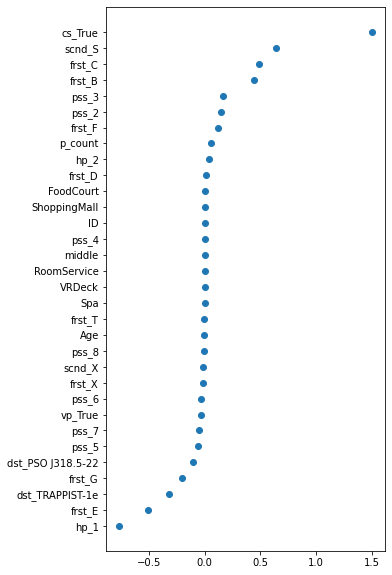

In [293]:
plt.figure(figsize=(5, 10))
index = np.argsort(clf.coef_[0])
plt.plot(clf.coef_[0][index], df.columns[:-1][index], "o")
plt.show()

In [295]:
depth = []
score = []

for dep in tqdm(range(3, 30, 1)):
    clf = RandomForestClassifier(max_depth=dep)
#     clf = KNeighborsClassifier(n_neighbors=dep)
    
    clf.fit(X_train, y_train)
    depth.append(dep)

    score.append(np.sum(clf.predict(X_val) == y_val) / len(y_val))

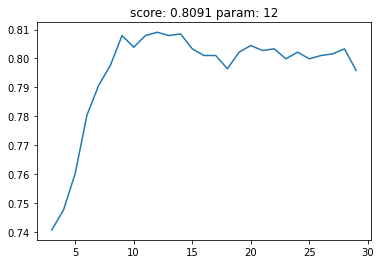

In [296]:
plt.plot(depth, score)
plt.title("score: " + str(round(max(score), 4)) + " param: " + str(depth[np.argmax(score)]))
plt.show()

In [320]:
class RSwA:
    def __init__(self, X, y, iterations=100, 
                 manipulations=None, model=None, desired_score=None, test_size=0.5):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.iterations = iterations
        self.manipulations = manipulations
        self.desired_score = desired_score
        self.model = model
        
        self.genes     = np.ones((len(manipulations), X.shape[1]))
        self.weights   = np.ones((len(manipulations), X.shape[1]))
        self.d_weights = pd.DataFrame(columns=[str(i) for i in range(len(manipulations) * X.shape[1])])
        
        self.cv_best_score = [] # лучшее качество в поколении
        self.best_genes = None  # лучший набор ген
        self.at_iteration = 0   # ...на итерации
        self.cv_all_scores = []
        self.score = 0
        self.count = 0  
    
    def set_genes(self):
        b = np.array([int(i) for i in self.manipulations]).reshape(len(self.manipulations), 1)  
        self.weights = self.weights * b
        a = self.weights.ravel().copy()
        shoots = int(b.sum() * self.weights.shape[1] * 0.5)

        for i in range(1, len(a), 1):
            a[i] = a[i] + a[i-1]

        for i in range(0, len(a), 1):
            a[i] = a[i] / a.max()

        indexes = set()
            
#         while len(indexes) < shoots:
        for i in range(shoots):    
            shoot = np.random.random()

            k = 0
            while  k < len(a) and a[k] < shoot:
                k += 1

            indexes.add(k)
        
        shape = self.weights.shape
        genes = [0] * shape[0] * shape[1]

        for i in range(len(genes)):
            if i in indexes:
                genes[i] = 1

        self.genes = np.reshape(genes, shape)
#         plot_importance2(rs.genes, text="what to use")

    def add_feature(self):
        # формирование признаков по заданным в хромосоме манипуляциям
        X_new = []
        for i in range(self.X.shape[1]): 
            if self.genes[0, i]: X_new.append(self.X[:, i])
            if self.genes[1, i]: X_new.append(self.X[:, i]**2)
            if self.genes[2, i] and 0 not in self.X[:, i]: X_new.append(1 / self.X[:, i])
    #         if self.genes[3, i]: X_new.append(np.exp(self.X[:, i]))
            if self.genes[3, i]: X_new.append(np.sin(self.X[:, i]))

        X_new = np.array(X_new).T
        return X_new

    def fitness_func(self):  
        # расчет качества модели по скользящему контролю
        X_new = self.add_feature()
        X_train, X_test, y_train, y_test = train_test_split(X_new, self.y,
                                                            test_size=self.test_size,
                                                            stratify=self.y)
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        
        cv_score = accuracy_score(y_test, predict)
        
        self.count += 1
        self.cv_all_scores.append(cv_score)

        if cv_score > self.score:
            self.score = cv_score
            self.best_genes = self.genes
            self.at_iteration = self.count

        return (cv_score)

    def change_weights(self, adapt):
#         plot_importance2(rs.weights, text="weights")
        a = self.weights.ravel().copy()
        g = self.genes.ravel().copy()

        for i in range(len(a)):
            if g[i]:
                a[i] = a[i] * adapt
        
        self.weights = np.reshape(a, self.weights.shape)
        
        temporary = pd.DataFrame([a], columns=self.d_weights.columns)
        self.d_weights = self.d_weights.append(temporary, ignore_index=True)
#         plot_importance2(rs.weights, text="weights")
        
    def go_search(self):
        
        for index, i in enumerate(self.manipulations):
            if i and self.weights[index, :].sum() == 0.0:
                self.weights[index, :] = 1
        
        self.set_genes()
        self.add_feature()
        self.fitness_func()
        
        if len(self.cv_all_scores) == 1:
            return   
        
#         print("было: ", self.cv_all_scores[-2], "стало: ", self.cv_all_scores[-1])
        
        if self.cv_all_scores[-1] > self.cv_all_scores[-2] * 1.01:
            self.change_weights(1.1)    
        elif self.cv_all_scores[-1] < self.cv_all_scores[-2] * 0.99:
            self.change_weights(0.9) 

In [321]:
def plot_results(vmin=0, vmax=1, initial_score=0):
    if echo:
        print("Best chromosome:\n", rs.best_genes,
          "\n\nwith score: ", rs.score, " at iteration # ", rs.at_iteration)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3)) 

    axes[0].plot(np.log(rs.d_weights), label="weights",)
    axes[0].set_ylabel('log(weights)')
    axes[0].set_xlabel('iterations')    
    
    axes[1].plot(rs.cv_all_scores, label="selected features")
    axes[1].set_ylabel("log loss")
#     axes[1].plot([0, len(rs.cv_all_scores) - 1], [1, 1], c="k")
    axes[1].plot([0, len(rs.cv_all_scores) - 1], [initial_score, initial_score], c="r", label="all features")
    axes[1].set_xlabel('iterations')
    axes[1].set_ylim(vmin, vmax)
#     axes[0].set_ylim(vmin, vmax)
    plt.legend(loc='lower right')
    plt.show()

In [322]:
manipulations = ["x", "x2", "1/x", "sin(x)"] # допустимые манипуляции над признаками

In [330]:
# model = LogisticRegression(max_iter=500)
# model = RandomForestClassifier(max_depth=13)
# model = GradientBoostingClassifier()
model = LGBMClassifier()

rs = RSwA(np.array(X),
          np.array(y),          # передаем признаки и целевую переменную
          iterations=500,        # число итераций
          manipulations="1000", # какие манипуляции над признаками пробовать
          model=model,          # модель
          desired_score=None,   # желаемое качество
          test_size=0.8)   

for i in tqdm(range(rs.iterations)):
    rs.go_search()
    
    if rs.desired_score is not None and rs.desired_score >= rs.score:
        break
    
print("*** DONE ***")


*** DONE ***


Best chromosome:
 [[0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]] 

with score:  0.7850467289719626  at iteration #  231


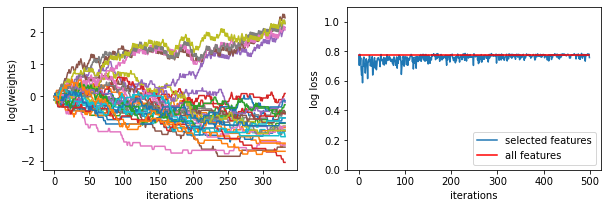

In [395]:
echo = True
plot_results(vmin=0.0, vmax=1.1, initial_score=initial_score)

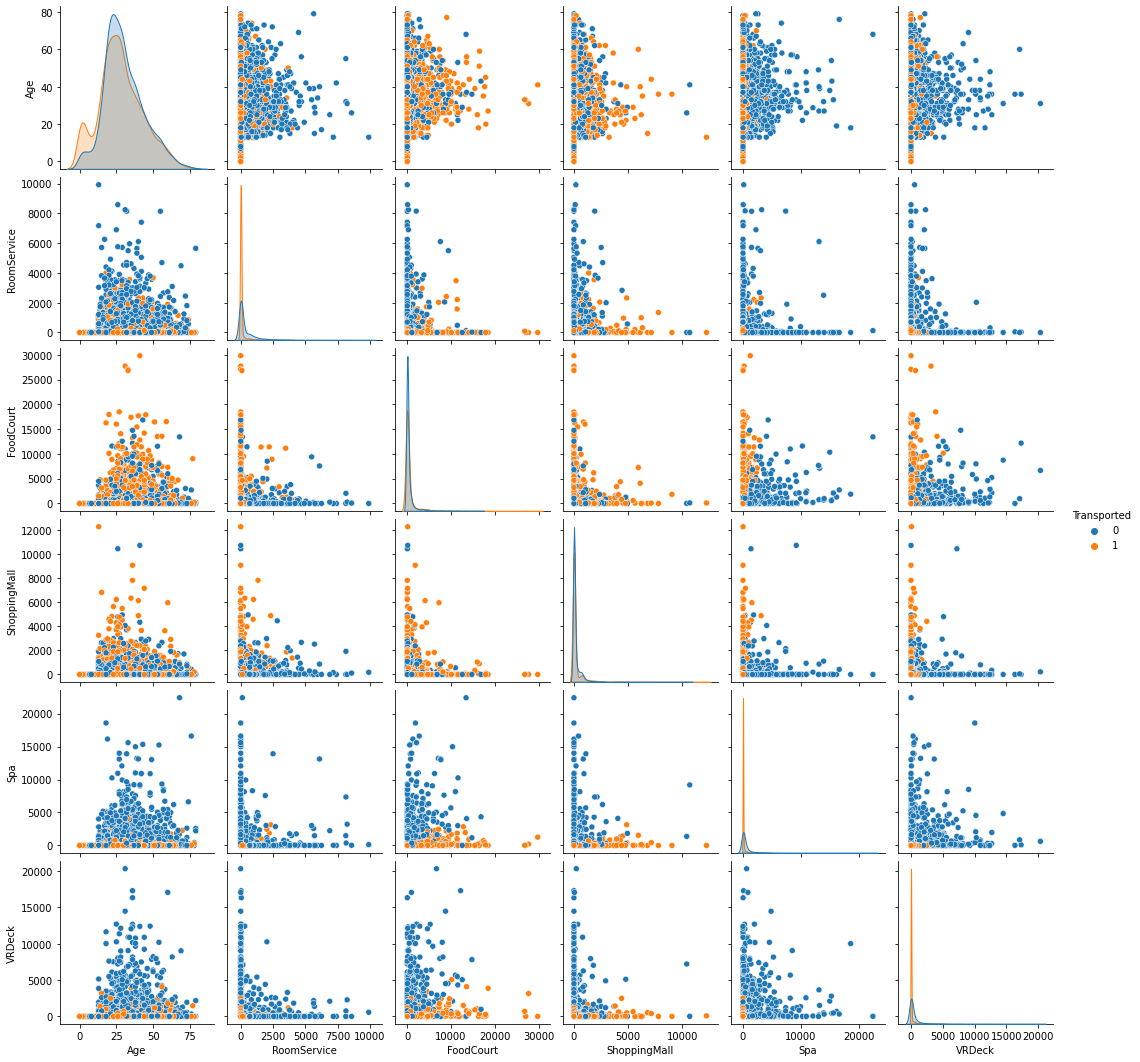

In [131]:
sns.pairplot(data[data[target] != -1].dropna().select_dtypes(include=["float", "int"]), hue=target)

In [145]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,12970.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000,12970.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482,0.007787
std,14.236710,647.596664,1584.370747,590.558690,1130.279641,1180.097223,0.816884
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,49.000000,77.000000,29.000000,57.000000,42.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [169]:
cols = train.select_dtypes(include=["float", "int"]).columns

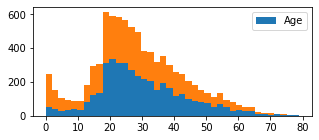

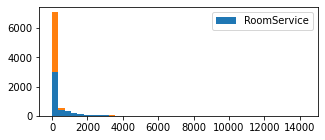

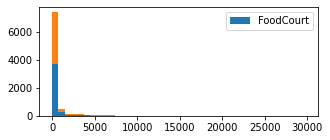

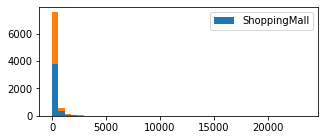

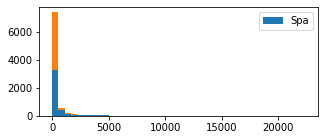

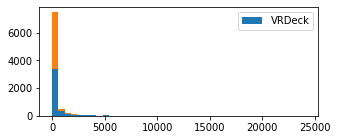

In [171]:
for col in cols:
    plt.figure(figsize=(5, 2))
    plt.hist([train[train[target] == 0][col], train[train[target] == 1][col]], stacked=True, bins=40, label=col)
    plt.legend()
    plt.show()

In [180]:
cols = train.select_dtypes(exclude=["float", "int"]).columns
cols[1: -2]

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP'], dtype='object')

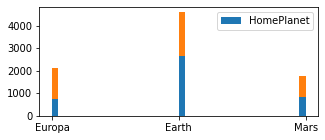

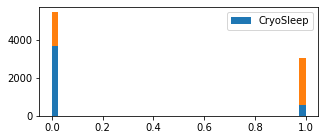

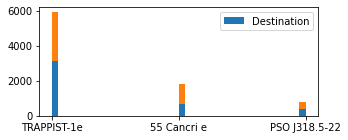

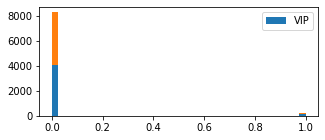

In [197]:
for col in cols[1: -2]:
    if train[train[target] == 0][col].dropna().nunique() > 20:
        continue
    
    plt.figure(figsize=(5, 2))
    plt.hist([train[train[target] == 0][col].dropna(), train[train[target] == 1][col].dropna()],
             stacked=True, bins=40, label=col)
    plt.legend()
    plt.show()

In [202]:
cabin = train[["Cabin", target]].copy()

cabin["first"] = cabin["Cabin"].str[0]
cabin["second"] = cabin["Cabin"].str[-1]

cols = ["first", "second"]

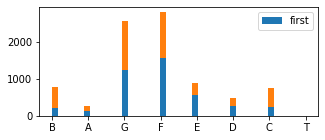

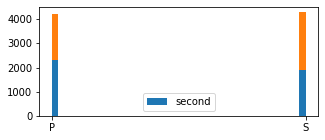

In [203]:
for col in cols:
    plt.figure(figsize=(5, 2))
    plt.hist([cabin[cabin[target] == 0][col].dropna(), cabin[cabin[target] == 1][col].dropna()],
             stacked=True, bins=40, label=col)
    plt.legend()
    plt.show()

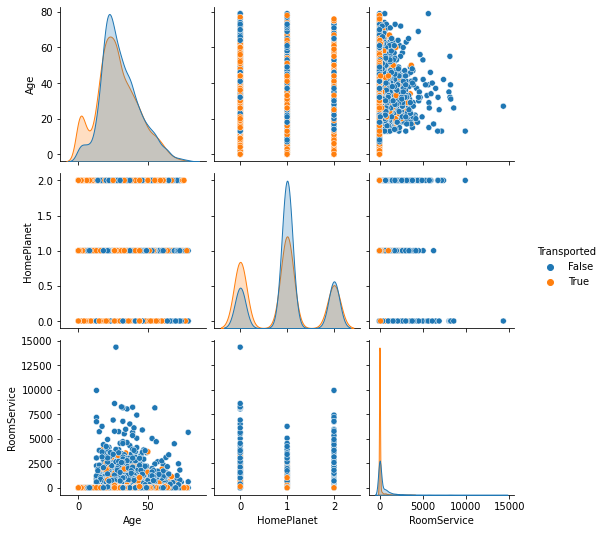

In [237]:
# selected = train[["Age", "HomePlanet", "RoomService", target]].dropna().copy()

sns.pairplot(selected, hue=target)

In [236]:
selected["HomePlanet"].unique()

array([0, 1, 2])

In [234]:
mapping = {"Europa": 0, "Earth": 1, "Mars": 2}

selected["HomePlanet"] = selected["HomePlanet"].map(mapping)
selected["HomePlanet"] = selected["HomePlanet"].astype("int")

In [235]:
selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8141 entries, 0 to 8692
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          8141 non-null   float64
 1   HomePlanet   8141 non-null   int32  
 2   RoomService  8141 non-null   float64
 3   Transported  8141 non-null   bool   
dtypes: bool(1), float64(2), int32(1)
memory usage: 230.6 KB


In [80]:
data[data["CryoSleep"].isna() == True].sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
3839,4108_02,Europa,NaN,B/158/S,TRAPPIST-1e,47.0,False,27.0,2651.0,538.0,18.0,0.0,Tachium Aroodint,1
7936,8474_01,Earth,NaN,F/1632/S,55 Cancri e,21.0,False,39.0,53.0,94.0,33.0,518.0,Eriky Weaves,0
9448,1534_02,Mars,NaN,D/55/S,TRAPPIST-1e,33.0,False,3303.0,0.0,40.0,1.0,0.0,Krunch Rasty,-1
8958,0578_02,Earth,NaN,G/84/S,TRAPPIST-1e,44.0,False,0.0,0.0,0.0,0.0,0.0,Nance Hoppers,-1
5205,5552_01,Mars,NaN,F/1150/P,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,Skix Potie,0


In [77]:
indexes = data[data["HomePlanet"].isna() == True].index

data.loc[indexes, "HomePlanet"] = "NoName"

In [78]:
data["HomePlanet"].value_counts()

Earth     6865
Europa    3133
Mars      2684
NoName     288
Name: HomePlanet, dtype: int64

In [81]:
indexes = data[data["CryoSleep"].isna() == True].index

data.loc[indexes, "CryoSleep"] = -1

In [82]:
data["CryoSleep"].value_counts()

False    8079
True     4581
-1        310
Name: CryoSleep, dtype: int64

In [84]:
indexes = data[data["Destination"].isna() == True].index

data.loc[indexes, "Destination"] = "Nowhere"

In [85]:
data["Destination"].value_counts()

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Nowhere           274
Name: Destination, dtype: int64

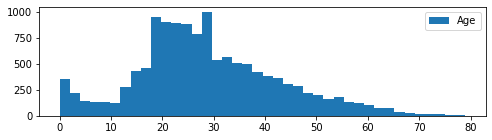

In [98]:
plt.figure(figsize=(8, 2))
plt.hist(data["Age"], bins=40, label="Age")
plt.legend()
plt.show()

In [97]:
indexes = data[data["Age"].isna() == True].index

data.loc[indexes, "Age"] = data["Age"].mean()


In [ ]:
indexes = data[data["VIP"].isna() == True].index

data.loc[indexes, "VIP"] = False

In [99]:
data["VIP"].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

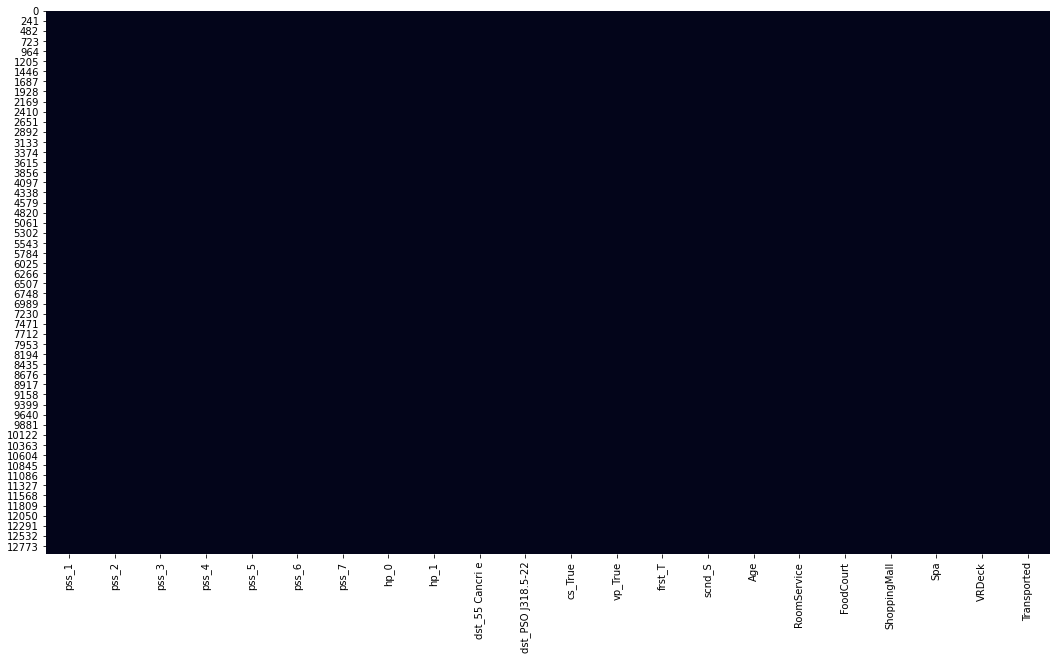

In [36]:
plt.figure(figsize=(18, 10))
sns.heatmap(df.isna(), cbar=False)
plt.show()

In [202]:
data = pd.DataFrame({"par": ["home", "home", "work", "work", "work", "city", "city"],
                     "target": [0, 0, 1, 1, 0, 1, 0]})
data

,par,target
0,home,0
1,home,0
2,work,1
3,work,1
4,work,0
5,city,1
6,city,0


In [203]:
dumm = pd.get_dummies(data["par"])
dumm

,city,home,work
0,0,1,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1
5,1,0,0
6,1,0,0


In [204]:
df1 = pd.concat([dumm, data["target"]], axis=1)
df1

,city,home,work,target
0,0,1,0,0
1,0,1,0,0
2,0,0,1,1
3,0,0,1,1
4,0,0,1,0
5,1,0,0,1
6,1,0,0,0


In [205]:
df2 = pd.DataFrame()

df2["home"] = df1["home"].map(df1.groupby("home")["target"].mean())
df2["work"] = df1["work"].map(df1.groupby("work")["target"].mean())
df2["city"] = df1["city"].map(df1.groupby("city")["target"].mean())
df2["target"] = data["target"]
df2

,home,work,city,target
0,0.0,0.250000,0.4,0
1,0.0,0.250000,0.4,0
2,0.6,0.666667,0.4,1
3,0.6,0.666667,0.4,1
4,0.6,0.666667,0.4,0
5,0.6,0.250000,0.5,1
6,0.6,0.250000,0.5,0


In [206]:
df3 = pd.DataFrame()

df3["par"] = data["par"].map(data.groupby("par")["target"].mean())
df3["target"] = data["target"]
df3

,par,target
0,0.000000,0
1,0.000000,0
2,0.666667,1
3,0.666667,1
4,0.666667,0
5,0.500000,1
6,0.500000,0


In [207]:
X = df1.drop("target", axis=1)
y = df1["target"]

clf = LogisticRegression()
clf.fit(X, y)

clf.predict(X), clf.coef_

(array([0, 0, 1, 1, 1, 0, 0], dtype=int64),
 array([[ 0.1219559 , -0.56499599,  0.44304331]]))

In [208]:
scaler = StandardScaler()

In [209]:
X = df2.drop("target", axis=1)

X = scaler.fit_transform(X)

clf = LogisticRegression()
clf.fit(X, y)

clf.predict(X), clf.coef_

(array([0, 0, 1, 1, 1, 0, 0], dtype=int64),
 array([[0.61428057, 0.42436514, 0.14941185]]))

In [210]:
X = df3.drop("target", axis=1)

X = scaler.fit_transform(X)

clf = LogisticRegression()
clf.fit(X, y)

clf.predict(X), clf.coef_

(array([0, 0, 1, 1, 1, 0, 0], dtype=int64), array([[0.78308442]]))